# HW3-2: MNIST 手写数字识别 （80分）

- 本次作业的主题是使用深度学习技术对`MNIST`手写数字数据集进行分类。
- 要求使用两种不同的深度学习模型，分别是多层感知机--`MLP`和卷积神经网络--`CNN`。
- 本次作业的目的是让同学们了解深度学习模型的构建和训练过程，以及对经典视觉任务处理效果的对比。

## 评分标准（更细致的评分标准见对应部分）

- 数据读取和预处理：5分
- 基于`MLP`的手写数字分类：30分 
- 基于`CNN`的手写数字分类：30分
- 结果讨论与对比分析：15分


---

## 第一部分：数据读取和预处理

你可以在Canvas上下载如下两个文件：
- 训练数据：`mnist_train.csv`
- 测试数据：`mnist_test.csv`

这两个文件包含了Mnist数据集的训练集和测试集。每一行的第一个数字表示标签，后面的784数字是28x28的图片像素值。
- 请你正确读取并分别展示训练集和测试集的第一个样本（图像+label）。

### 评分细则
- 数据读取：2分
- 数据展示：3分

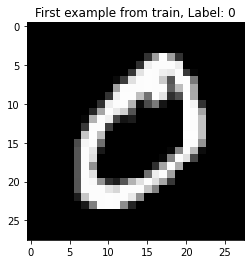

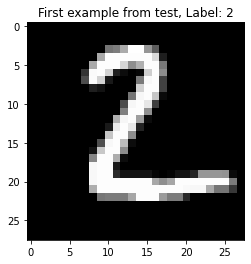

In [5]:
# Code Here
import pandas as pd
from matplotlib import pyplot as plt
import torch

test_path = "mnist_test.csv"
train_path = "mnist_train.csv"


class DataLoader:
    def __init__(self, path):
        self.data = pd.read_csv(path)
    
    @staticmethod    
    def load_data(path):
        data = pd.read_csv(path)
        return data

    def get_row_i(self, i):
        label = self.data.iloc[i, 0]
        image = self.data.iloc[i, 1:].values.reshape(28, 28)
        return label, image

    @staticmethod
    def get_batch(data, batch_size):
        for i in range(0, len(data), batch_size):
            yield data[i:i+batch_size, 0], data[i:i+batch_size, 1:].reshape(-1, 28, 28)
            
    def get_loader(self, batch_size):
        # turn into torch tensor
        dataset = []
        for labels, images in self.get_batch(self.data.values, batch_size):
            labels = torch.tensor(labels, dtype=torch.long)
            images = torch.tensor(images, dtype=torch.float32)
            dataset.append((labels, images))
        return dataset

train_dataloader = DataLoader(train_path)
test_dataloader = DataLoader(test_path)

train_first_label, train_first_image = train_dataloader.get_row_i(0)
test_first_label, test_first_image = test_dataloader.get_row_i(0)

plt.title(f"First example from train, Label: {train_first_label}")
plt.imshow(train_first_image, cmap="gray")
plt.show()

plt.title(f"First example from test, Label: {test_first_label}")
plt.imshow(test_first_image, cmap="gray")
plt.show()


---
## 第二部分：基于`MLP`的手写数字分类

- 请你构建一个多层感知机模型，在Mnist数据集上进行训练和测试。
- 可以使用`Pytorch`或者`Tensorflow`等深度学习框架。
- 请你展示模型的训练过程（Loss曲线）和测试结果（分类精度）。

### 评分细则
- 模型构建：10分
- 模型训练：10分 - 要求Loss曲线收敛
- 模型测试：10分 - 要求分类精度达到90%以上

In [33]:
# Code here
import numpy as np
import torch
from tqdm import tqdm
import time

import torch.nn.functional as F
# train the model

criterion = torch.nn.CrossEntropyLoss()

def train(model, train_loader, test_loader, epochs=10, lr=0.01, save_path = None):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    epoch_loss_list = []
    epoch_accuracy = []
    step_loss_list = []
    bar = tqdm(range(epochs), total=epochs, desc="Training")
    train_time = 0

    for epoch in bar:
        epoch_loss = 0
        model.train()
        start = time.time()
        for labels, images in train_loader:
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels.long())
            
            loss.backward()
            epoch_loss += loss.item()
            step_loss_list.append(loss.item())
            optimizer.step()
        
        end = time.time()
        
        train_time += end-start
        
        epoch_loss_list.append(epoch_loss)
        model.eval()
        correct = 0
        total = 0
        for labels, images in test_loader:
            output = model(images)
            predicted = model.predict(images)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        bar.set_description_str(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}, Accuracy: {correct/total if total != 0 else 0}")
        epoch_accuracy.append(correct/total)
    print(f"Training time: {train_time:.2f}s")
    
    if save_path:
        torch.save(model.state_dict(), save_path)
    return epoch_loss_list, step_loss_list, epoch_accuracy

def plot_func(epoch_loss_list, epoch_accuracy_list, model_name, thres = 0.98):

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epoch_loss_list)
    plt.title(f"{model_name} Epoch Loss")

    plt.subplot(1, 2, 2)
    plt.plot(epoch_accuracy_list)
    plt.axvline(np.argmax(np.array(epoch_accuracy_list) > thres), color="red", linestyle="--")

    plt.text(np.argmax(np.array(epoch_accuracy_list) > thres), thres - 0.005, f"Epoch {np.argmax(np.array(epoch_accuracy_list) > thres)}")
    plt.title(f"{model_name} Epoch Accuracy")
    plt.show()



In [61]:
class Improved_MLP(torch.nn.Module):
    def __init__(self):
        super(Improved_MLP, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 256)
        self.bn1 = torch.nn.BatchNorm1d(256)
        self.fc2 = torch.nn.Linear(256, 128)
        self.bn2 = torch.nn.BatchNorm1d(128)
        self.fc3 = torch.nn.Linear(128, 64)
        self.bn3 = torch.nn.BatchNorm1d(64)
        self.fc4 = torch.nn.Linear(64, 10)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            x = x.view(-1, 28*28)
            x = F.relu(self.bn1(self.fc1(x)))
            x = F.relu(self.bn2(self.fc2(x)))
            x = F.relu(self.bn3(self.fc3(x)))
            x = self.fc4(x)
            return torch.argmax(x, dim=1)
 
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 256)
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc3 = torch.nn.Linear(128, 64)
        self.fc4 = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu((self.fc1(x)))
        x = F.relu((self.fc2(x)))
        x = F.relu((self.fc3(x)))
        x = self.fc4(x)
        return x

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            x = x.view(-1, 28*28)
            x = F.relu((self.fc1(x)))
            x = F.relu((self.fc2(x)))
            x = F.relu((self.fc3(x)))
            x = self.fc4(x)
            return torch.argmax(x, dim=1)
        
class LargeMLP(torch.nn.Module):
    def __init__(self):
        super(LargeMLP, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 512)  
        self.bn1 = torch.nn.BatchNorm1d(512)
        self.fc2 = torch.nn.Linear(512, 256)    
        self.bn2 = torch.nn.BatchNorm1d(256)
        self.fc3 = torch.nn.Linear(256, 128)    
        self.bn3 = torch.nn.BatchNorm1d(128)
        self.fc4 = torch.nn.Linear(128, 64)     
        self.bn4 = torch.nn.BatchNorm1d(64)
        self.fc5 = torch.nn.Linear(64, 32)      
        self.bn5 = torch.nn.BatchNorm1d(32)
        self.fc6 = torch.nn.Linear(32, 10)      
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        x = F.relu(self.bn5(self.fc5(x)))
        x = self.fc6(x)
        return x
    
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            x = x.view(-1, 28*28)
            x = F.relu(self.bn1(self.fc1(x)))
            x = F.relu(self.bn2(self.fc2(x)))
            x = F.relu(self.bn3(self.fc3(x)))
            x = F.relu(self.bn4(self.fc4(x)))
            x = F.relu(self.bn5(self.fc5(x)))
            x = self.fc6(x)
            return torch.argmax(x, dim=1)
 

In [9]:
# traditional MLP
train_loader = train_dataloader.get_loader(64) # batch_size = 64
test_loader = test_dataloader.get_loader(64)

model = MLP()

epoch_loss_list_mlp, step_loss_list_mlp, epoch_accuracy_mlp = train(model, train_loader, test_loader, epochs=1000, lr=0.01, save_path="mlp.pth")

Epoch 1000/1000, Loss: 0.0013567726375123268, Accuracy: 0.9815981598159816: 100%|██████████| 1000/1000 [11:00<00:00,  1.51it/s]

Training time: 627.21s


In [10]:
# improved MLP model
train_loader = train_dataloader.get_loader(64) # batch_size = 64
test_loader = test_dataloader.get_loader(64)

model = Improved_MLP()

epoch_loss_list_improved_mlp, step_loss_list_improved_mlp, epoch_accuracy_improved_mlp = train(model, train_loader, test_loader, epochs=1000, lr=0.01, save_path="improved_mlp.pth")

Epoch 1000/1000, Loss: 11.202272430640733, Accuracy: 0.9817981798179818: 100%|██████████| 1000/1000 [40:56<00:00,  2.46s/it]

Training time: 2344.56s


In [62]:
# large MLP model
train_loader = train_dataloader.get_loader(64) # batch_size = 64
test_loader = test_dataloader.get_loader(64)

model = LargeMLP()

epoch_loss_list_large_mlp, step_loss_list_large_mlp, epoch_accuracy_large_mlp = train(model, train_loader, test_loader, epochs=1000, lr=0.01, save_path="large_mlp.pth")

Epoch 1000/1000, Loss: 6.62186915339953, Accuracy: 0.9852985298529853: 100%|██████████| 1000/1000 [1:19:39<00:00,  4.78s/it]

Training time: 4555.57s


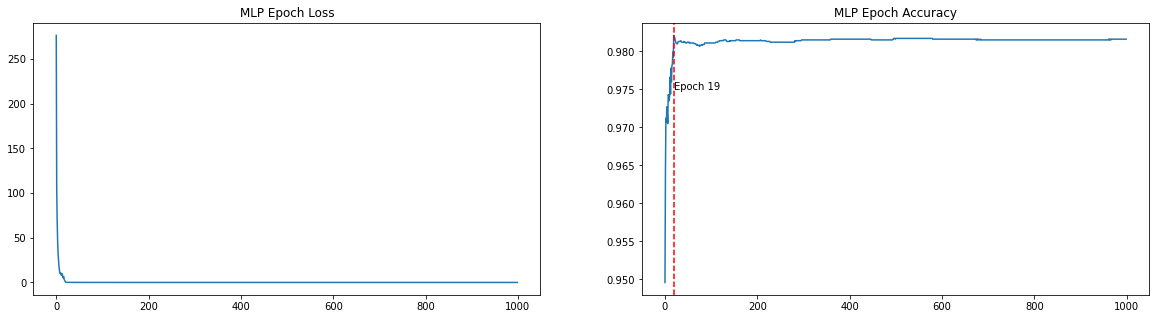

In [34]:
# plot epoch loss for MLP
plot_func(epoch_loss_list_mlp, epoch_accuracy_mlp, "MLP")

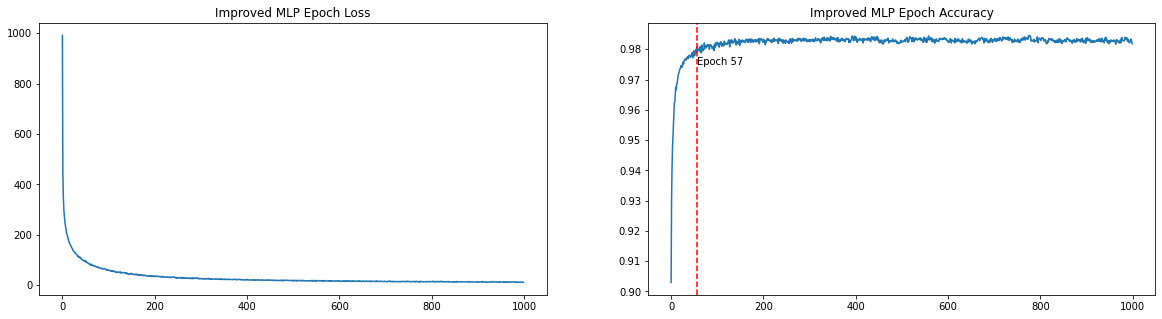

In [35]:
# plot epoch loss for improved MLP
plot_func(epoch_loss_list_improved_mlp, epoch_accuracy_improved_mlp, "Improved MLP")

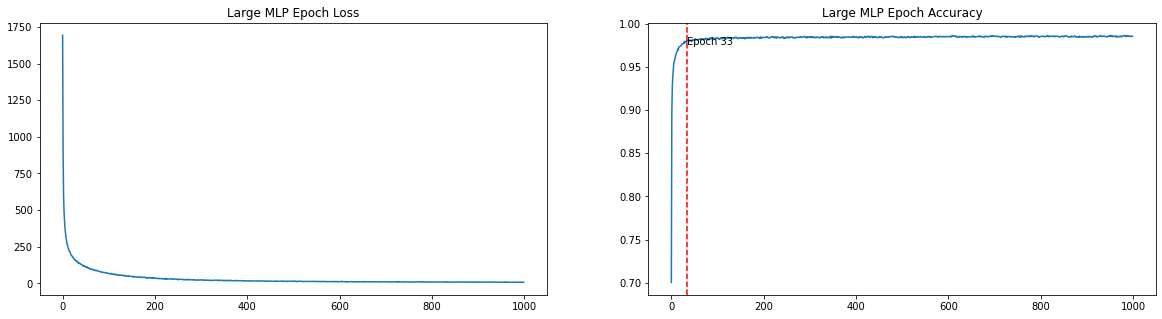

In [63]:
# plot epoch loss for large MLP
plot_func(epoch_loss_list_large_mlp, epoch_accuracy_large_mlp, "Large MLP")

---
## 第三部分：基于`CNN`的手写数字分类

- 请你构建一个卷积神经网络模型，在Mnist数据集上进行训练和测试。
- 可以使用`Pytorch`或者`Tensorflow`等深度学习框架。
- 请你展示模型的训练过程（Loss曲线）和测试结果（分类精度）。

### 评分细则
- 模型构建：10分
- 模型训练：10分 - 要求Loss曲线收敛
- 模型测试：10分 - 要求分类精度达到95%以上

In [49]:
# Code here

import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128) 
        self.fc2 = nn.Linear(128, 10) 

    def forward(self, x):
        if x.shape[0] != 1:
            x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            x = self.forward(x)
            return torch.argmax(x, dim=1)

class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        if x.shape[0] != 1:
            x = x.unsqueeze(1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            x = self.forward(x)
            return torch.argmax(x, dim=1)



In [ ]:
model = CNN()
epoch_loss_list_cnn, step_loss_list_cnn, epoch_accuracy_cnn = train(model, train_loader, test_loader, epochs=50, lr=0.01, save_path="cnn.pth")

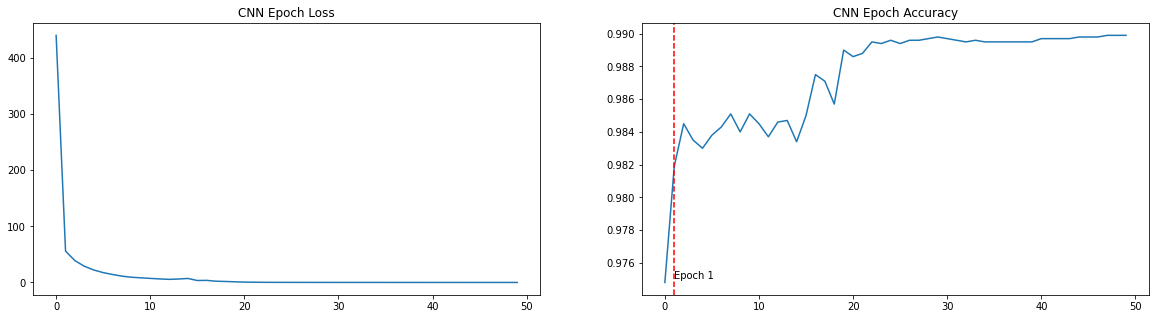

In [37]:
# plot epoch loss
plot_func(epoch_loss_list_cnn, epoch_accuracy_cnn, "CNN")

In [70]:
model = ImprovedCNN()
epoch_loss_list_improved_cnn, step_loss_list_improved_cnn, epoch_accuracy_improved_cnn = train(model, train_loader, test_loader, epochs=150, lr=0.01, save_path="improved_cnn.pth")

Training:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 150/150, Loss: 1.6086869107085704, Accuracy: 0.9928992899289929: 100%|██████████| 150/150 [1:16:56<00:00, 30.78s/it]

Training time: 4163.69s


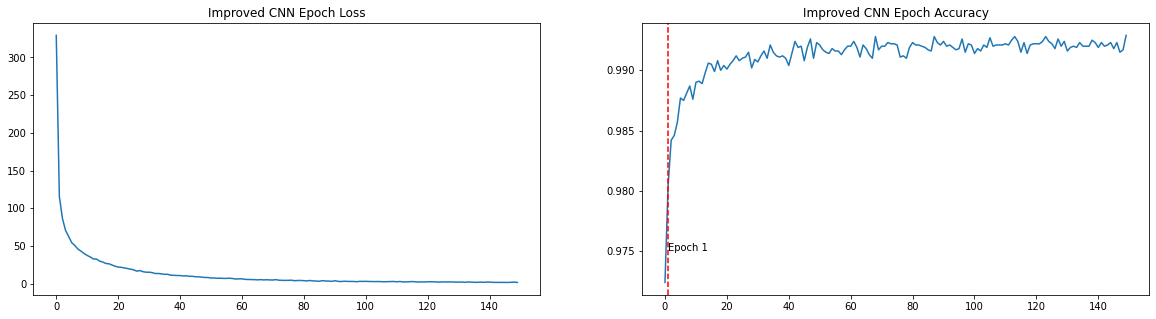

In [71]:
# plot epoch loss
plot_func(epoch_loss_list_improved_cnn, epoch_accuracy_improved_cnn, "Improved CNN")

In [77]:
# test generalizabilty
import cv2
import time

class Timer:
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start


cnn = CNN()
improved_mlp = Improved_MLP()
mlp = MLP()
large_mlp = LargeMLP()
improved_cnn = ImprovedCNN()


cnn_state = torch.load("cnn.pth")
improved_mlp_state = torch.load("improved_mlp.pth")
mlp_state = torch.load("mlp.pth")
improved_cnn_state = torch.load("improved_cnn.pth")
large_mlp_state = torch.load("large_mlp.pth")

# get the size of the checkpoint in KB
import os
print(f"Size of CNN checkpoint: {os.path.getsize('cnn.pth') / 1024:.2f}KB")
print(f"Size of Improved MLP checkpoint: {os.path.getsize('improved_mlp.pth') / 1024:.2f}KB")
print(f"Size of MLP checkpoint: {os.path.getsize('mlp.pth') / 1024:.2f}KB")
print(f"Size of Improved CNN checkpoint: {os.path.getsize('improved_cnn.pth') / 1024:.2f}KB")
print(f"Size of Large MLP checkpoint: {os.path.getsize('large_mlp.pth') / 1024:.2f}KB")


# load the model
cnn.load_state_dict(cnn_state)
improved_mlp.load_state_dict(improved_mlp_state)
mlp.load_state_dict(mlp_state)
improved_cnn.load_state_dict(improved_cnn_state)
large_mlp.load_state_dict(large_mlp_state)



data_path = "unseen"

# load imgs from unseen folder
import os
imgs = os.listdir(data_path)

cnn.eval()
improved_mlp.eval()
mlp.eval()
improved_cnn.eval()

cnn_correct = 0
improved_mlp_correct = 0
mlp_correct = 0
improved_cnn_correct = 0
large_mlp_correct = 0

inference_time_cnn = 0
inference_time_improved_mlp = 0
inference_time_mlp = 0
inference_time_improved_cnn = 0
inference_time_large_mlp = 0

for img in imgs:
    img_path = os.path.join(data_path, img)
    label = int(img.split("_")[-1].split(".")[0])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (28, 28))
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    with Timer() as t:
        cnn_pred = cnn.predict(img)
    inference_time_cnn += t.interval

    with Timer() as t:
        improved_mlp_pred = improved_mlp.predict(img)
    inference_time_improved_mlp += t.interval

    with Timer() as t:
        mlp_pred = mlp.predict(img)
    inference_time_mlp += t.interval

    with Timer() as t:
        improved_cnn_pred = improved_cnn.predict(img)
    inference_time_improved_cnn += t.interval
    
    with Timer() as t:
        large_mlp_pred = large_mlp.predict(img)
    inference_time_large_mlp += t.interval
    
    if cnn_pred == label:
        cnn_correct += 1
    if improved_mlp_pred == label:
        improved_mlp_correct += 1
    if mlp_pred == label:
        mlp_correct += 1
    if improved_cnn_pred == label:
        improved_cnn_correct += 1
    if large_mlp_pred == label:
        large_mlp_correct += 1
    
    print(f"Image: {img_path}, Label: {label}, CNN: {cnn_pred.item()}, Improved MLP: {improved_mlp_pred.item()}, MLP: {mlp_pred.item()}, Improved CNN: {improved_cnn_pred.item()}, Large MLP: {large_mlp_pred.item()}")


print(f"CNN Accuracy: {cnn_correct/len(imgs)}")
print(f"Improved MLP Accuracy: {improved_mlp_correct/len(imgs)}")
print(f"MLP Accuracy: {mlp_correct/len(imgs)}")
print(f"Improved CNN Accuracy: {improved_cnn_correct/len(imgs)}")
print(f"Large MLP Accuracy: {large_mlp_correct/len(imgs)}")

print("-----------------")

print(f"CNN Inference Time: {inference_time_cnn / len(imgs):.3e}s")
print(f"Improved MLP Inference Time: {inference_time_improved_mlp / len(imgs):.3e}s")
print(f"MLP Inference Time: {inference_time_mlp / len(imgs):.3e}s")
print(f"Improved CNN Inference Time: {inference_time_improved_cnn / len(imgs):.3e}s")
print(f"Large MLP Inference Time: {inference_time_large_mlp / len(imgs):.3e}s")

Size of CNN checkpoint: 1649.16KB
Size of Improved MLP checkpoint: 961.90KB
Size of MLP checkpoint: 950.41KB
Size of Improved CNN checkpoint: 1653.89KB
Size of Large MLP checkpoint: 2279.07KB
Image: unseen/unseen_9.jpg, Label: 9, CNN: 9, Improved MLP: 9, MLP: 4, Improved CNN: 9, Large MLP: 9
Image: unseen/unseen_5.jpg, Label: 5, CNN: 5, Improved MLP: 5, MLP: 5, Improved CNN: 5, Large MLP: 5
Image: unseen/unseen_4.jpg, Label: 4, CNN: 4, Improved MLP: 7, MLP: 9, Improved CNN: 4, Large MLP: 9
Image: unseen/unseen_7.jpg, Label: 7, CNN: 3, Improved MLP: 1, MLP: 7, Improved CNN: 9, Large MLP: 7
Image: unseen/unseen_1.jpg, Label: 1, CNN: 9, Improved MLP: 1, MLP: 9, Improved CNN: 1, Large MLP: 1
CNN Accuracy: 0.6
Improved MLP Accuracy: 0.6
MLP Accuracy: 0.4
Improved CNN Accuracy: 0.8
Large MLP Accuracy: 0.8
-----------------
CNN Inference Time: 4.902e-04s
Improved MLP Inference Time: 1.326e-04s
MLP Inference Time: 6.852e-05s
Improved CNN Inference Time: 6.088e-04s
Large MLP Inference Time: 1.8


---
## 第四部分：结果讨论与对比分析

- 请你对`MLP`和`CNN`两种模型的训练和测试结果进行对比分析。
- 你可以从模型的训练速度、模型的性能、模型的泛化能力等方面进行分析。
    - 训练速度：模型训练所需的时间
    - 模型性能：模型在测试集上的分类精度
    - 模型泛化能力：模型在未知数据上的表现，未知数据可以从Canvas上下载，在文件夹`unseen`中有5张手写数字图片。
- 请在下面的markdown cell中写下你的分析结果。

### 评分细则
- 结果讨论与对比分析：
    - 训练速度：4分
    - 模型性能：4分
    - 模型泛化能力：5分
    - 其他：2分

## 结果表格

| Metric / Model               | MLP       | Improved MLP | CNN       | Improved CNN |
|:----------------------------:|:---------:|:------------:|:---------:| :---------:|
| Total training time / s               | 627.21    | 2344.56      | 1226.45  | 4163.69  |
| Epoch | 1000 | 1000 | 50 | 150 |
| Time per epoch / s              | 0.62 |  2.34   | 24.53 | 27.76 |
| Time to reach > 98% accuracy /s | $\approx$ 11.78  | $\approx$ 133.38    |  $\approx$ 24.53 | $\approx$ 27.76  |
| Inference time $^{*}$ / s | 6.938e-05  | 1.436e-04    | 6.846e-04 | 6.088e-04  |
| Final accuracy on test set           | 98.16 %    | 98.18 %    | 98.99 % | 99.28%  |
| generalizability | 40%  | 60%     | 60%  | 80% |
| model size / KB | 950.41  |  961.90    |1649.16   | 1653.89 |




----

> Epoch的选择取决于loss曲线是否收敛

> *inference time 存在浮动，仅仅为参考值

## 训练速度
在batch_size, learning rate和训练数据集都相同的情况下，如果就训练相同epoch数所需的时间而言，CNN所需的时间约为 `24.53 s / epoch`, 而添加了batch norm和dropout操作的CNN（**下面我们统称improved CNN**）所需的时间约为 `27.76 s / epoch` .

对比之下，MLP的训练时间会少很多，MLP的时间约为 `0.62s / epoch`, 添加了batch norm和dropout操作的MLP（**下面我们统称improved MLP**）所需的时间为  `2.34s / epoch`. 

而如果我们比较模型达到98%的准确度所需要的时间，相较于 improved MLP，两种CNN的效率会更高一些，分别需要约 24.53s和27.76s就可以达到98%的分类准确率，但最快的还是朴素MLP，仅需要约11.78s.


## 模型性能

从表中可以看出，MLP模型的分类性能均低于CNN模型的性能，相差了约0.8～1个百分点，此外，添加batchnorm和dropout后，两种模型的性能均有所提高。

## 模型泛化能力

从测试结果可以看出，传统MLP模型的泛化能力是弱于CNN模型的，结合网上资料分析来看，MLP模型相对CNN更容易过拟合，这是因为MLP模型是一个全连接网络，每个神经元与前后层的所有神经元相连接，这种结构在面对复杂的图像或高维数据时，很容易学到过多的细节而非抽象的、更具普适性的特征，从而导致过拟合。相比之下，CNN通过使用卷积层，专注于提取局部特征，并通过参数共享和池化层的使用，增强了模型对于输入数据变化的鲁棒性。而添加batchnorm和dropout操作可以提高模型的泛化能力，这是因为batchnorm和dropout方法都有助于减少模型过拟合。

## 模型大小

| Metric / Model               | Large MLP       | 
|:----------------------------:|:---------:|
| Total training time / s               | 4555.57   | 
| Epoch | 1000 |
| Final accuracy on test set           | 98.52 %    |
| generalizability | 80%  | 
| model size / KB | 2279.07KB  |

从模型大小上来分析，本次实验中使用的两个CNN模型的大小约为MLP和improved MLP模型的 1.7 倍。考虑到模型大小对模型性能的影响，我又尝试增加MLP的参数量（Large MLP) 进行了实验， 其参数大小为 2279.07KB。然后，其性能并没有超过CNN模型，在测试集上的accuracy为98.52%, 泛化表现为80%, 可见使CNN模型性能更好的原因并非是其更大的参数量，而是其模型的架构。这也让我不禁期待，在transformer处处可见的当下，能否有更多诸如 Mamba 的对transformer这一基础框架进行挑战的工作。